In [1]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import davies_bouldin_score

import pickle
import copy
from shapely import geometry
from sklearn.metrics.pairwise import euclidean_distances
import statsmodels.api as sm
from scipy.stats import linregress
from sklearn.metrics import accuracy_score
import math
import matplotlib.lines as mlines
from scipy.stats import ks_2samp

In [2]:
path_anoms = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/LENS_poly_v3/'
files = np.sort(glob.glob(f'{path_anoms}*'))
names_exp = np.array([files[id_exp].split('_')[-1][:-7] for id_exp in range(len(files))])

In [3]:
import pandas as pd
import xarray as xr

# Create a dictionary to store data for all experiments
data_dict = {}

# Read data for all experiments and store them in the dictionary
for id_exp, exp_name in enumerate(names_exp):
    # Read the labels dataframe
    labels_df = pd.read_csv(f'../Data_v3/LENS2/Labels/df_labels_{exp_name}.csv',
                            index_col=0, parse_dates=True, names=['WR'], skiprows=1)
    
    # Read the distances dataframe
    distances_df = pd.read_csv(f'../Data_v3/LENS2/Distances/df_labels_{exp_name}.csv',
                               index_col=0, parse_dates=True, names=['distance'], skiprows=1)
    
    # Read the composites/averages xarray DataArray
    composites_da = xr.open_dataset(f'../Data_v3/LENS2/avgs/avgs_{exp_name}.nc').Z_anoms
    
    # Store the read data in the dictionary under the experiment name
    data_dict[exp_name] = {'labels': labels_df, 'distances': distances_df, 'composites': composites_da}


In [4]:
# Define a function to convert a date into a season
def get_season(date):
    """Map a date to its corresponding season."""
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

# Loop through each experiment in the data dictionary
for exp_name, data in data_dict.items():
    # Assuming data['labels'] is a DataFrame with a 'time' column of datetime type
    # if 'time' in data['labels'].columns:
    # Add a new column 'season' to the labels DataFrame based on the 'time' column
    data['labels']['season'] = data['labels'].index.map(get_season)
    data['distances']['season'] = data['labels'].index.map(get_season)
    # else:
    #     print(f"Experiment {exp_name} does not have a 'time' column in its labels DataFrame.")

In [5]:
names = ["Greenland High", "Alaskan Ridge", "Pacific High", "Atlantic High", "Pacific Trough" ,"No WR"]

# composites full

In [6]:
n_labels = len(names)

In [7]:
import xarray as xr

# Initialize lists to collect the composites for each label (assuming 6 labels)
all_composites = {label: [] for label in range(n_labels)}

# Loop through each experiment and extract the composites for each label
for exp_name in data_dict:
    composites_da = data_dict[exp_name]['composites']
    
    # Add the composite of each label to the corresponding list
    for label in range(n_labels):
        all_composites[label].append(composites_da.sel(wr=label))

# Compute mean and standard deviation for each label across all experiments
mean_composites = {}
std_composites = {}

for label, composite_list in all_composites.items():
    # Concatenate all composites for the current label along a new dimension 'experiment'
    combined_composites = xr.concat(composite_list, dim='experiment')
    
    # Compute mean and standard deviation along the 'experiment' dimension
    mean_composites[label] = combined_composites.mean(dim='experiment')
    std_composites[label] = combined_composites.std(dim='experiment')

In [8]:
# Step 1: Calculate frequency of each label for each experiment
frequencies = {}
for exp_name, data in data_dict.items():
    label_counts = data['labels']['WR'].value_counts().sort_index()  # Count occurrences of each label
    frequencies[exp_name] = label_counts

# Convert frequencies to a DataFrame to facilitate computation along the experiment (column) axis
frequencies_df = pd.DataFrame(frequencies).fillna(0)  # Fill missing values with 0 if some labels are not present in some experiments

# Step 2: Calculate mean and standard deviation of frequencies across experiments
mean_frequencies = frequencies_df.mean(axis=1)  # Mean frequency of each label across experiments
std_frequencies = frequencies_df.std(axis=1)    # Standard deviation of each label's frequency across experiments

# Step 1: Calculate total time steps for each experiment
total_time_steps = {exp_name: len(data_dict[exp_name]['labels']) for exp_name in data_dict}

# Convert the total time steps dictionary to a list
total_time_steps_list = list(total_time_steps.values())

# Calculate the mean total time steps
mean_total_time_steps = sum(total_time_steps_list) / len(total_time_steps_list)

# Step 2: Convert frequencies to percentages
mean_frequencies_percentage = (mean_frequencies / mean_total_time_steps) * 100
std_frequencies_percentage = (std_frequencies / mean_total_time_steps) * 100

# Display the results
print("Mean Frequencies of Each Label Across Models (Percentage):\n", mean_frequencies_percentage)
print("Standard Deviation of Frequencies of Each Label Across Models (Percentage):\n", std_frequencies_percentage)

Mean Frequencies of Each Label Across Models (Percentage):
 0    16.746813
1    14.036603
2    18.475251
3    18.961753
4    20.093297
5    11.686283
dtype: float64
Standard Deviation of Frequencies of Each Label Across Models (Percentage):
 0    0.260875
1    0.271673
2    0.285558
3    0.314146
4    0.303657
5    0.296238
dtype: float64


In [9]:
def plot_multiple_maps(dic_mean,dic_std,freqs_mean, freqs_std,
                       regioncoords, names = None, path_save=None, n_cols=2):
    """
    Plot multiple maps from a list of data arrays with a fixed number of columns and dynamic rows.
    
    Parameters:
    - da_list: list of xarray.DataArray objects to plot.
    - n_cols: Number of columns for the subplot grid (default is 2).
    """

    min_lon, max_lon, min_lat, max_lat = regioncoords
    # Convert longitudes from 0-360 to -180-180 if necessary
    def convert_lon(lon):
        return lon if lon <= 180 else lon - 360
    
    min_lon_converted = convert_lon(min_lon)
    max_lon_converted = convert_lon(max_lon)
    
    # Number of maps to plot
    n_maps = len(dic_mean)
    
    # Determine the number of rows needed
    n_rows = math.ceil(n_maps / n_cols)
    
    # Create a figure with the calculated number of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 2 * (n_rows)),
                             subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-100)})

    # If there's only one row, axes will not be a 2D array, so we need to adjust for that
    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)
    
    # Plot each DataArray in the provided list
    for i in range(len(dic_mean)-1):
        row = i // n_cols
        col = i % n_cols
        
        ax = axes[row, col]

        # Convert longitudes to -180 to 180 range
        lon = (dic_mean[0].lon + 180) % 360 - 180
    
        # Adjust data array to match the longitude range
        da_shifted, lon_shifted = xr.broadcast(dic_mean[i], lon)
        
        # Plot the rectangle to highlight the specified region
        rect_style = {'edgecolor': 'black', 'facecolor': 'gray', 'linewidth': 1.5, 'alpha':0.2}
        
        if min_lon_converted < max_lon_converted:
            # Normal case, region does not cross the antimeridian
            ax.add_patch(plt.Rectangle(
                (min_lon_converted, min_lat), max_lon_converted - min_lon_converted, max_lat - min_lat,
                transform=ccrs.PlateCarree(), **rect_style, zorder=2))
        else:
            # Special case for regions crossing the antimeridian
            ax.add_patch(plt.Rectangle(
                (min_lon_converted, min_lat), 180 - min_lon_converted, max_lat - min_lat,
                transform=ccrs.PlateCarree(), **rect_style, zorder=2))
            ax.add_patch(plt.Rectangle(
                (-180, min_lat), max_lon_converted + 180, max_lat - min_lat,
                transform=ccrs.PlateCarree(), **rect_style, zorder=2))

        ax.set_extent([-100, 100, 10, 90], crs=ccrs.PlateCarree(central_longitude=-100))

        # Add gridlines every 20 degrees
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.2, color='gray', alpha=0.5, linestyle='--')
        gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 60))
        gl.ylocator = plt.FixedLocator(np.arange(0, 91, 20))
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LongitudeFormatter(zero_direction_label=True)
        gl.yformatter = LatitudeFormatter()

        tick_fontsize = 10
        # Set font size for tick labels
        gl.xlabel_style = {'size': tick_fontsize}
        gl.ylabel_style = {'size': tick_fontsize}

        # Plot the data using pcolormesh
        mini=-2.5
        maxi=2.5
        intervals = 21
        bounds=np.linspace(mini,maxi,intervals)
        # print(da_shifted)
        mesh = ax.contourf(lon_shifted.lon, da_shifted.lat, da_shifted.values, levels=bounds, vmin=mini, vmax=maxi,
                                 cmap='RdYlBu_r', transform=ccrs.PlateCarree(),extend='both')
        
        # Add standard deviation contours and labels
        contour_std = ax.contour(lon_shifted.lon, da_shifted.lat, dic_std[i].values, colors='k',
                                 transform=ccrs.PlateCarree(), linewidths=0.3)
        ax.clabel(contour_std, inline=True, fontsize=8, fmt='%1.1f')

        # Add coastlines for context
        ax.coastlines()

        # Set title for each subplot
        if names:
            ax.set_title(f'{names[i]} - Freq.: {np.round(freqs_mean[i],2)}% +- {np.round(freqs_std[i],2)}%',fontsize=11)
        else:
            ax.set_title(f'Cluster {i+1} - Freq.: {np.round(freqs_mean[i],2)}% +- {np.round(freqs_std[i],2)}%',fontsize=11)

    # Hide any unused subplots
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[j // n_cols, j % n_cols])

    # # Adjust layout to prevent overlapping
    plt.tight_layout(w_pad=0.1)
    # Alternatively, adjust spacing between plots using subplots_adjust
    # fig.subplots_adjust(hspace=-0.7, wspace=0.3)  # Adjust these parameters as needed


    cax = fig.add_axes([0.6, 0.2, 0.325, 0.03])  # Example position: horizontal, below the main plot
    
    # Add a horizontal colorbar
    cbar = fig.colorbar(mesh, cax=cax, orientation='horizontal')
    cbar.set_label(r'Z Anomaly ($\sigma$)')

    # main_title = f"Region: {min_lon,max_lon,min_lat,max_lat}"
    # Add the overall title for the figure
    fig.suptitle('ERA5 - Weather Regimes', fontsize=14, y=1.04,ha='center')

    if path_save==False:
        # Show the plot
        plt.show()
        plt.close('all')
    else:
        plt.savefig(path_save, bbox_inches='tight',dpi=200)
        plt.close('all')

In [10]:
region = [180, 330, 20, 80]
plot_multiple_maps(mean_composites,std_composites,
                   mean_frequencies_percentage,std_frequencies_percentage,
                   region,names=names, 
                   path_save=f'../Figures_v3/LENS_WRs/CompositesLENS.png')

# frequencies plot

In [11]:
# Initialize dictionaries to store overall and seasonal frequencies
frequencies = {}
seasonal_frequencies = {}

# List of seasons to consider
seasons = ['Winter', 'Spring', 'Summer', 'Fall']

# Loop through each experiment in the data dictionary
for exp_name, data in data_dict.items():
    # Step 1: Calculate overall frequency for the experiment
    label_counts = data['labels']['WR'].value_counts().sort_index()  # Count occurrences of each label
    frequencies[exp_name] = label_counts
    
    # Step 2: Calculate seasonal frequencies for the experiment
    # Initialize a dictionary to store seasonal frequencies for this experiment
    seasonal_freq_exp = {season: np.zeros(label_counts.index.max() + 1) for season in seasons}

    # Loop through each season and calculate the frequency of each WR label
    for season in seasons:
        # Filter data for the current season
        season_data = data['labels'][data['labels']['season'] == season]

        # Count occurrences of each WR label in this season
        season_label_counts = season_data['WR'].value_counts().sort_index()

        # Compute relative frequency (percentage of total seasonal occurrences)
        if len(season_data) > 0:
            season_freq = (season_label_counts / len(season_data)) * 100
        else:
            # If no data points in this season, set frequency to 0 for all labels
            season_freq = pd.Series(0, index=season_label_counts.index)

        # Store frequencies in the seasonal dictionary
        seasonal_freq_exp[season][season_freq.index] = season_freq.values

    # Store the seasonal frequencies for this experiment in the main seasonal_frequencies dictionary
    seasonal_frequencies[exp_name] = seasonal_freq_exp

In [12]:
# Initialize dictionaries to store mean frequencies across all experiments
mean_frequencies = np.zeros(frequencies[next(iter(frequencies))].index.max() + 1)
mean_seasonal_frequencies = {season: np.zeros_like(mean_frequencies) for season in seasons}

# Number of experiments
n_experiments = len(frequencies)

# Step 1: Calculate the mean overall frequency
for exp_name, freq in frequencies.items():
    mean_frequencies[freq.index] += freq.values

# Divide by the number of experiments to get the mean
mean_frequencies /= n_experiments

# Step 2: Calculate the mean seasonal frequencies
for exp_name, season_freqs in seasonal_frequencies.items():
    for season, season_freq in season_freqs.items():
        mean_seasonal_frequencies[season] += season_freq

# Divide by the number of experiments to get the mean for each season
for season in mean_seasonal_frequencies:
    mean_seasonal_frequencies[season] /= n_experiments

# # Print results to check
# print("Mean Frequencies Overall: ", mean_frequencies)
# for season, mean_season_freq in mean_seasonal_frequencies.items():
#     print(f"Mean Seasonal Frequency for {season}: {mean_season_freq}")

In [13]:
# Print the resulting dictionary
frequencies_perc = {}
for model, series in frequencies.items():
    frequencies_perc[model] = 100 * frequencies[model]/np.sum(frequencies[model])

In [14]:
seasons = ['Winter', 'Spring', 'Summer', 'Fall', 'all']

dic_seasonal_frequencies = {}
for season in seasons:
    dic_season = {}
    for exp_name in data_dict.keys():
        if season == 'all':
            dic_season[exp_name] = frequencies_perc[exp_name]
        else:
            dic_season[exp_name] = seasonal_frequencies[exp_name][season]
    dic_seasonal_frequencies[season] = pd.DataFrame(dic_season)

In [15]:
stats_freq = {}
stats_freq['p95'] = {}
stats_freq['p5'] = {}
stats_freq['mean'] = {}

for season in seasons:
    stats_freq['p5'][season] = dic_seasonal_frequencies[season].quantile(0.05,axis=1)
    stats_freq['p95'][season] = dic_seasonal_frequencies[season].quantile(0.95,axis=1)
    stats_freq['mean'][season] = dic_seasonal_frequencies[season].mean(axis=1)

In [25]:
# Function to plot the bars and lines using an axes object
def plot_frequency(ax, mean_seasonal_freqs, p5_seasonal_freqs, p95_seasonal_freqs,
                   names, seasons):
    # Define a color palette or use specific colors for each reanalysis
    bar_width = 0.2  # Width of each bar
    x = np.arange(len(names))  # X positions for the groups
    colors_seasons = {'Winter':'darkturquoise',
                      'Spring':'limegreen',
                      'Summer':'darkorange',
                      'Fall':'darkorchid',
                      'all':'grey'}
    # Plot bars for this reanalysis
    for season in seasons:
        if season=='all':
            ax.bar(x, mean_seasonal_freqs[season], 
                   width=bar_width, color=colors_seasons[season], label='All year')
        else:
            ax.plot(x, mean_seasonal_freqs[season], marker='o', 
                    linestyle='-', label=f'{season}',color=colors_seasons[season])
    
    # print(yearly_freqs)
    # print(x + ir * bar_width)
    # print(percentiles_5)
    # Plot the 95th and 5th percentiles as error bars
    
    for season in seasons:
        if season == 'all':
            ax.vlines(x, p5_seasonal_freqs['all'], p95_seasonal_freqs['all'], color='k', lw=1.5)
            ax.hlines(p5_seasonal_freqs[season], x - 0.08, x + 0.08, color='k', lw=1.5)
            ax.hlines(p95_seasonal_freqs[season], x - 0.08, x + 0.08, color='k', lw=1.5)
        else:
            ax.vlines(x, p5_seasonal_freqs[season], p95_seasonal_freqs[season], color=colors_seasons[season], lw=1.5)
            ax.hlines(p5_seasonal_freqs[season], x - 0.04, x + 0.04, color=colors_seasons[season], lw=1.5)
            ax.hlines(p95_seasonal_freqs[season], x - 0.04, x + 0.04, color=colors_seasons[season], lw=1.5)

        
    # Set x-ticks and labels
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=0, fontsize=12)
    ax.set_yticks(np.arange(0, 36, 5))
    ax.tick_params(axis='y', labelsize=12)
    ax.set_ylim(0, 35)

    # Add labels and title
    ax.set_xlabel('Weather Regimes', fontsize=14)
    ax.set_ylabel('Frequency (%)', fontsize=14)
    ax.set_title('Overall Frequency of Weather Regimes - LENS', fontsize=14)
    ax.legend()


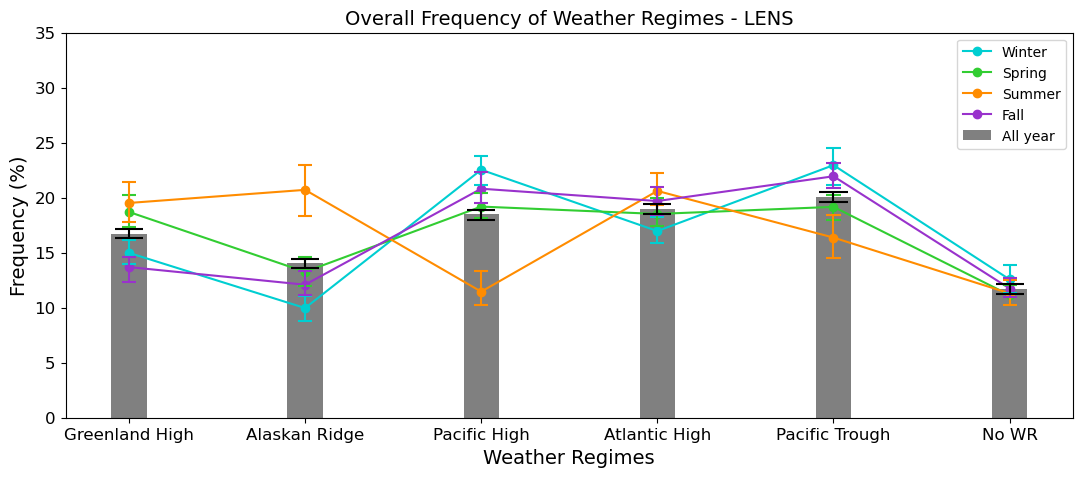

In [26]:
## Days per season
# # Example of usage:
fig, ax = plt.subplots(figsize=(13, 5))
plot_frequency(ax, stats_freq['mean'], stats_freq['p5'], stats_freq['p95'],names,seasons)
plt.savefig('../Figures_v3/LENS_WRs/LENS_SeasonalFrequencies.png',bbox_inches='tight')

# Event-wise plots

In [27]:
def get_events(df_labels):
    # Step 1: Identify changes in class to find the start of each event
    df_labels['shifted'] = df_labels['WR'].shift(1)
    df_labels['start'] = df_labels['WR'] != df_labels['shifted']
    df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
    df_labels['start_date'].fillna(method='ffill', inplace=True)
    
    # Step 2: Calculate the duration of each event
    # Convert the Timedelta to its 'days' component
    df_labels['duration'] = (df_labels.index - df_labels['start_date']).dt.days + 1
    
    # Step 3: Create the df_events DataFrame
    # Group by 'start_date' and 'class' to get the duration of each class event
    df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max'}).reset_index()
    
    # Drop the temporary columns used for calculations
    df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)
    
    # Set 'start_date' as the index if needed
    df_events.set_index('start_date', inplace=True)
    
    return df_events

In [28]:
for exp_name in names_exp:
    data_dict[exp_name]['events'] = get_events(data_dict[exp_name]['labels'])
for exp_name, data in data_dict.items():
    # Assuming data['labels'] is a DataFrame with a 'time' column of datetime type
    # if 'time' in data['labels'].columns:
    # Add a new column 'season' to the labels DataFrame based on the 'time' column
    data['events']['season'] = data['events'].index.map(get_season)

In [29]:
dic_durations = {}
for season in seasons:
    dic_temp = {}
    for exp_name in names_exp:
        list_durs_wrs = []
        for wr in range(len(names)):
            if season!='all':
                dur_temp = data_dict[exp_name]['events']\
                    [(data_dict[exp_name]['events']['season'] == season)&\
                    (data_dict[exp_name]['events']['WR'] == wr)]['duration']
            else:
                dur_temp = data_dict[exp_name]['events'][(data_dict[exp_name]['events']['WR'] == wr)]['duration']
            mean_temp = dur_temp.mean()
            list_durs_wrs.append(mean_temp)
        dic_temp[exp_name] = list_durs_wrs
    dic_durations[season] = pd.DataFrame(dic_temp)

In [30]:
stats_durations = {}
stats_durations['p95'] = {}
stats_durations['p5'] = {}
stats_durations['mean'] = {}

for season in seasons:
    stats_durations['p5'][season] = dic_durations[season].quantile(0.05,axis=1)
    stats_durations['p95'][season] = dic_durations[season].quantile(0.95,axis=1)
    stats_durations['mean'][season] = dic_durations[season].mean(axis=1)

In [31]:
# Function to plot the bars and lines using an axes object
def plot_durations(ax, mean_seasonal_durs, p5_seasonal_durs, p95_seasonal_durs,
                   names, seasons):
    # Define a color palette or use specific colors for each reanalysis
    bar_width = 0.2  # Width of each bar
    x = np.arange(len(names))  # X positions for the groups
    colors_seasons = {'Winter':'darkturquoise',
                      'Spring':'limegreen',
                      'Summer':'darkorange',
                      'Fall':'darkorchid',
                      'all':'grey'}
    # Plot bars for this reanalysis
    for season in seasons:
        if season=='all':
            ax.bar(x, mean_seasonal_durs[season], 
                   width=bar_width, color=colors_seasons[season], label='All year')
        else:
            ax.plot(x, mean_seasonal_durs[season], marker='o', 
                    linestyle='-', label=f'{season}',color=colors_seasons[season])
    
    # print(yearly_freqs)
    # print(x + ir * bar_width)
    # print(percentiles_5)
    # Plot the 95th and 5th percentiles as error bars
    
    for season in seasons:
        if season == 'all':
            ax.vlines(x, p5_seasonal_durs['all'], p95_seasonal_durs['all'], color='k', lw=1.5)
            ax.hlines(p5_seasonal_durs[season], x - 0.08, x + 0.08, color='k', lw=1.5)
            ax.hlines(p95_seasonal_durs[season], x - 0.08, x + 0.08, color='k', lw=1.5)
        else:
            ax.vlines(x, p5_seasonal_durs[season], p95_seasonal_durs[season], color=colors_seasons[season], lw=1.5)
            ax.hlines(p5_seasonal_durs[season], x - 0.04, x + 0.04, color=colors_seasons[season], lw=1.5)
            ax.hlines(p95_seasonal_durs[season], x - 0.04, x + 0.04, color=colors_seasons[season], lw=1.5)

        
    # Set x-ticks and labels
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=0, fontsize=12)
    # ax.set_yticks(np.arange(0, 36, 5))
    ax.tick_params(axis='y', labelsize=12)
    ax.set_ylim(0, 11)

    # Add labels and title
    ax.set_xlabel('Weather Regimes', fontsize=14)
    ax.set_ylabel('Days', fontsize=14)
    ax.set_title('Overall duration of Weather Regimes - LENS', fontsize=14)
    ax.legend()


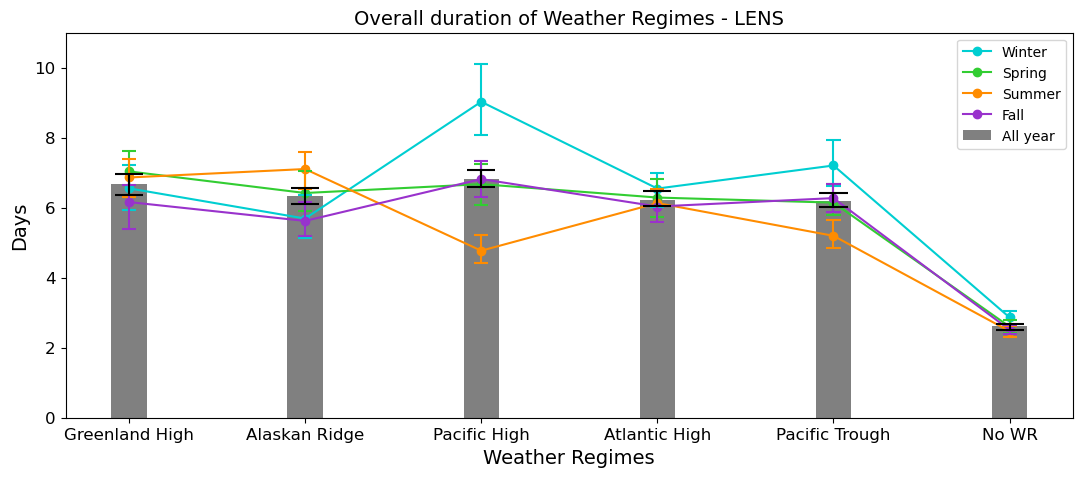

In [32]:
## Days per season
# # Example of usage:
fig, ax = plt.subplots(figsize=(13, 5))
plot_durations(ax, stats_durations['mean'], stats_durations['p5'], stats_durations['p95'],names,seasons)
plt.savefig('../Figures_v3/LENS_WRs/LENS_SeasonalDurations.png',bbox_inches='tight')

In [33]:
dic_nevents = {}
for season in seasons:
    dic_temp = {}
    for exp_name in names_exp:
        n_years = data_dict[exp_name]['events'].index[-1].year - data_dict[exp_name]['events'].index[0].year
        if (season == 'all'):
            evfreqs_temp = data_dict[exp_name]['events'].groupby('WR').count()['duration'].values/n_years
        else:
            evfreqs_temp = data_dict[exp_name]['events']\
                [data_dict[exp_name]['events']['season']==season].groupby('WR').count()['duration'].values/n_years
        dic_temp[exp_name] = evfreqs_temp
    dic_nevents[season] = pd.DataFrame(dic_temp)

In [34]:
stats_nevents = {}
stats_nevents['p95'] = {}
stats_nevents['p5'] = {}
stats_nevents['mean'] = {}

for season in seasons:
    stats_nevents['p5'][season] = dic_nevents[season].quantile(0.05,axis=1)
    stats_nevents['p95'][season] = dic_nevents[season].quantile(0.95,axis=1)
    stats_nevents['mean'][season] = dic_nevents[season].mean(axis=1)

In [35]:
stats_nevents['mean']['all']

0     9.284054
1     8.222432
2    10.033243
3    11.268108
4    11.988649
5    16.589189
dtype: float64

In [38]:
# Function to plot the bars and lines using an axes object
def plot_nevents(ax, mean_seasonal_nevs, p5_seasonal_nevs, p95_seasonal_nevs,
                   names, seasons):
    # Define a color palette or use specific colors for each reanalysis
    bar_width = 0.2  # Width of each bar
    x = np.arange(len(names))  # X positions for the groups
    colors_seasons = {'Winter':'darkturquoise',
                      'Spring':'limegreen',
                      'Summer':'darkorange',
                      'Fall':'darkorchid',
                      'all':'grey'}
    # Plot bars for this reanalysis
    for season in seasons:
        if season=='all':
            ax.bar(x, mean_seasonal_nevs[season]/4, 
                   width=bar_width, color=colors_seasons[season], label='All year')
        else:
            ax.plot(x, mean_seasonal_nevs[season], marker='o', 
                    linestyle='-', label=f'{season}',color=colors_seasons[season])
    
    # print(yearly_freqs)
    # print(x + ir * bar_width)
    # print(percentiles_5)
    # Plot the 95th and 5th percentiles as error bars
    
    for season in seasons:
        if season == 'all':
            ax.vlines(x, p5_seasonal_nevs['all']/4, p95_seasonal_nevs['all']/4, color='k', lw=1.5)
            ax.hlines(p5_seasonal_nevs[season]/4, x - 0.08, x + 0.08, color='k', lw=1.5)
            ax.hlines(p95_seasonal_nevs[season]/4, x - 0.08, x + 0.08, color='k', lw=1.5)
        else:
            ax.vlines(x, p5_seasonal_nevs[season], p95_seasonal_nevs[season], color=colors_seasons[season], lw=1.5)
            ax.hlines(p5_seasonal_nevs[season], x - 0.04, x + 0.04, color=colors_seasons[season], lw=1.5)
            ax.hlines(p95_seasonal_nevs[season], x - 0.04, x + 0.04, color=colors_seasons[season], lw=1.5)

        
    # Set x-ticks and labels
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=0, fontsize=12)
    # ax.set_yticks(np.arange(0, 36, 5))
    ax.tick_params(axis='y', labelsize=12)
    ax.set_ylim(0, 5.3)

    # Add labels and title
    ax.set_xlabel('Weather Regimes', fontsize=14)
    ax.set_ylabel('Number of events per season', fontsize=14)
    ax.set_title('Number of Events per Season - LENS', fontsize=14)
    ax.legend()


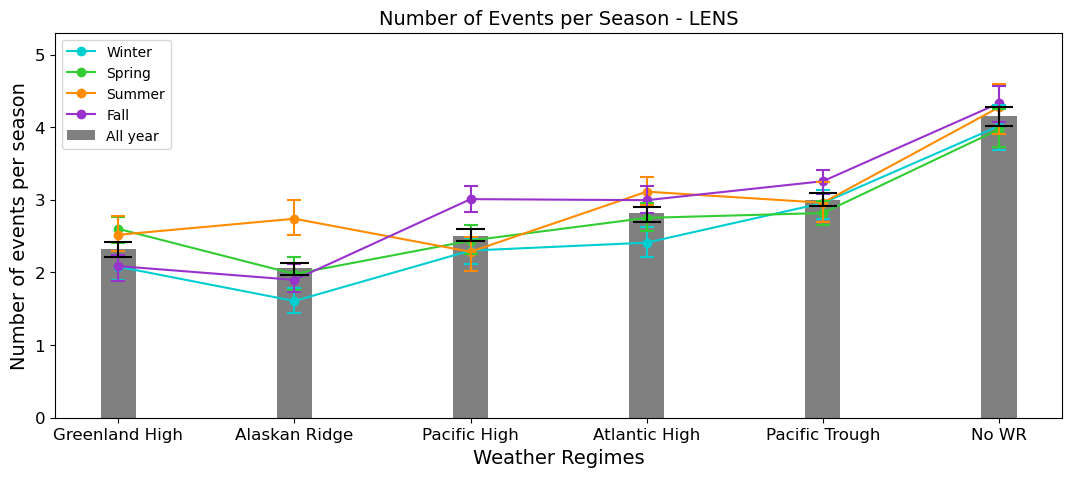

In [39]:
## Days per season
# # Example of usage:
fig, ax = plt.subplots(figsize=(13, 5))
plot_nevents(ax, stats_nevents['mean'], stats_nevents['p5'], stats_nevents['p95'],names,seasons)
plt.savefig('../Figures_v3/LENS_WRs/LENS_SeasonalNevents.png',bbox_inches='tight')

# Distance

In [128]:
seasons

['Winter', 'Spring', 'Summer', 'Fall', 'all']

In [153]:
dic_distances = {}
for season in seasons:
    dic_temp = {}
    for exp_name in names_exp:
        list_dists_wrs = []
        for wr in range(len(names)):
            if season!='all':
                dist_temp = data_dict[exp_name]['distances']\
                    [(data_dict[exp_name]['distances']['season'] == season)&\
                    (data_dict[exp_name]['labels']['WR'] == wr)]['distance']
            else:
                dist_temp = data_dict[exp_name]['distances'][(data_dict[exp_name]['labels']['WR'] == wr)]['distance']
            mean_temp = dist_temp.mean()
            list_dists_wrs.append(mean_temp)
        dic_temp[exp_name] = list_dists_wrs
    dic_distances[season] = pd.DataFrame(dic_temp)

In [156]:
stats_dist = {}
stats_dist['p95'] = {}
stats_dist['p5'] = {}
stats_dist['mean'] = {}

for season in seasons:
    stats_dist['p5'][season] = dic_distances[season].quantile(0.05,axis=1)
    stats_dist['p95'][season] = dic_distances[season].quantile(0.95,axis=1)
    stats_dist['mean'][season] = dic_distances[season].mean(axis=1)

In [125]:
# Function to plot the bars and lines using an axes object
def plot_distances(ax, mean_seasonal_dists, p5_seasonal_dists, p95_seasonal_dists,
                   names, seasons):
    # Define a color palette or use specific colors for each reanalysis
    bar_width = 0.2  # Width of each bar
    x = np.arange(len(names))  # X positions for the groups
    colors_seasons = {'Winter':'darkturquoise',
                      'Spring':'limegreen',
                      'Summer':'darkorange',
                      'Fall':'darkorchid',
                      'all':'grey'}
    # Plot bars for this reanalysis
    for season in seasons:
        if season=='all':
            ax.bar(x, mean_seasonal_freqs[season], 
                   width=bar_width, color=colors_seasons[season], label='All year')
        else:
            ax.plot(x, mean_seasonal_freqs[season], marker='o', 
                    linestyle='-', label=f'{season}',color=colors_seasons[season])
    
    # print(yearly_freqs)
    # print(x + ir * bar_width)
    # print(percentiles_5)
    # Plot the 95th and 5th percentiles as error bars
    
    for season in seasons:
        if season == 'all':
            ax.vlines(x, p5_seasonal_freqs['all'], p95_seasonal_freqs['all'], color='k', lw=1.5)
            ax.hlines(p5_seasonal_freqs[season], x - 0.08, x + 0.08, color='k', lw=1.5)
            ax.hlines(p95_seasonal_freqs[season], x - 0.08, x + 0.08, color='k', lw=1.5)
        else:
            ax.vlines(x, p5_seasonal_freqs[season], p95_seasonal_freqs[season], color=colors_seasons[season], lw=1.5)
            ax.hlines(p5_seasonal_freqs[season], x - 0.04, x + 0.04, color=colors_seasons[season], lw=1.5)
            ax.hlines(p95_seasonal_freqs[season], x - 0.04, x + 0.04, color=colors_seasons[season], lw=1.5)

        
    # Set x-ticks and labels
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=0, fontsize=12)
    ax.set_yticks(np.arange(0, 36, 5))
    ax.tick_params(axis='y', labelsize=12)
    ax.set_ylim(0, 5)

    # Add labels and title
    ax.set_xlabel('Weather Regimes', fontsize=14)
    ax.set_ylabel('Frequency (%)', fontsize=14)
    ax.set_title('Overall Frequency of Weather Regimes - LENS', fontsize=14)
    ax.legend()


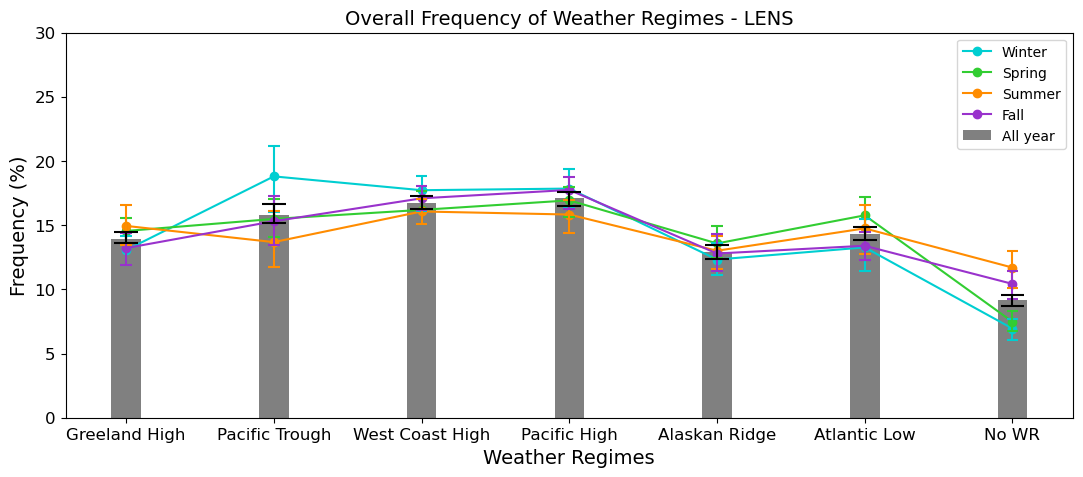

In [126]:
## Days per season
# # Example of usage:
fig, ax = plt.subplots(figsize=(13, 5))
plot_frequency(ax, stats_freq['mean'], stats_freq['p5'], stats_freq['p95'],names,seasons)
plt.savefig('../Figures/LENS_SeasonalFrequencies.png',bbox_inches='tight')